In [3]:
# 创建数据集
import torch

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.preprocessing.sequence import pad_sequences

## 构造数据

In [132]:
def sparseFeature(feat, feat_num, embed_dim=4):
    return {'feat':feat, 'feat_num':feat_num, 'embed_dim':embed_dim}
def denseFeature(feat):
    return {'feat':feat}
def create_amazon_electronic_dataset(file, embed_dim=8, maxlen=40):
	"""
	:param file: dataset path
	:param embed_dim: latent factor
	:param maxlen
	:return: user_num, item_num, train_df, test_df
	"""
	print('=========Data Preprocess Start===========')
	with open(file, 'rb') as f:
		reviews_df = pickle.load(f)
		cate_list = pickle.load(f)
		user_count, item_count, cate_count, example_count = pickle.load(f)
	reviews_df = reviews_df
	reviews_df.columns = ['user_id', 'item_id', 'time']

	train_data, val_data, test_data = [], [], []

	for user_id, hist in tqdm(reviews_df.groupby('user_id')):
		pos_list = hist['item_id'].tolist()             # pos_list就是用户真实购买的商品， 下面针对每个购买的商品， 产生一个用户没有购买过的产品

		def gen_neg():
			neg = pos_list[0]
			while neg in pos_list: 
				neg = random.randint(0, item_count-1)       # 这儿产生一个不在真实用户购买的里面的
			return neg
		neg_list = [gen_neg() for i in range(len(pos_list))]
		hist = []
		for i in range(1, len(pos_list)):
			hist.append([pos_list[i-1]])
			if i == len(pos_list) - 1:                   # 最后一个的时候
				test_data.append([hist, [pos_list[i]], 1])
				test_data.append([hist, [neg_list[i]], 0])
			elif i == len(pos_list) - 2:           # 倒数第二个的时候
				val_data.append([hist, [pos_list[i]], 1])
				val_data.append([hist, [neg_list[i]], 0])
			else:
				train_data.append([hist, [pos_list[i]], 1])
				train_data.append([hist, [neg_list[i]], 0])

	# feature columns
	feature_columns = [
		[],
		[sparseFeature('item_id', item_count, embed_dim)]
	]

	# behavior_list
	behavior_list = ['item_id']

	# shuffle
	random.shuffle(train_data)
	random.shuffle(val_data)
	random.shuffle(test_data)

	train = pd.DataFrame(train_data, columns=['hist', 'target_item', 'label'])
	val = pd.DataFrame(val_data, columns=['hist', 'target_item', 'label'])
	test = pd.DataFrame(test_data, columns=['hist', 'target_item', 'label'])

	# if no dense or sparse features, can fill with 0
	print('=================Padding================')



	train_X = [np.array([0.] * len(train)), np.array([0]*len(train)), pad_sequences(train['hist'], maxlen=maxlen), np.array(train['target_item'].tolist())]
	train_y = train['label'].values
	val_X = [np.array([0.] * len(val)), np.array([0]*len(val)), pad_sequences(val['hist'], maxlen=maxlen), np.array(val['target_item'].tolist())]
	val_y = val['label'].values
	test_X = [np.array([0.] * len(test)), np.array([0]*len(test)), pad_sequences(test['hist'], maxlen=maxlen), np.array(test['target_item'].tolist())]
	test_y = test['label'].values
	print('===========Data Preprocess End====================')
	return feature_columns, behavior_list, (train_X, train_y), (val_X, val_y), (test_X, test_y)

In [133]:
file_name = './remap.pkl'
feature_columns, behavior_list, (train_X, train_y), (val_X, val_y), (test_X, test_y) = create_amazon_electronic_dataset(file_name)

=========Data Preprocess Start===========


100%|██████████| 100000/100000 [00:14<00:00, 7088.66it/s]


=================Padding================
===========Data Preprocess End====================


In [249]:
print(len(train_X))
print(train_X[0].shape)
print(train_X[1].shape)
print(train_X[2].shape)
print(train_X[3].shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

4
(528800,)
(528800,)
(528800, 40, 1)
(528800, 1)
(528800,)
(159746,)
(184778,)


In [142]:
print(feature_columns, behavior_list)

[[], [{'feat': 'item_id', 'feat_num': 37392, 'embed_dim': 8}]] ['item_id']


In [254]:
dl_train_dataset = TensorDataset(torch.tensor(train_X[0].reshape(-1,1)).float(), torch.tensor(train_X[1].reshape(-1,1)).float(), torch.tensor(train_X[2]).float(), torch.tensor(train_X[3]).float(), torch.tensor(train_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_X[0].reshape(-1,1)).float(), torch.tensor(val_X[1].reshape(-1,1)).float(), torch.tensor(val_X[2]).float(), torch.tensor(val_X[3]).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=10000)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=10000)

for dense_input, sparse_input, behavior_data, target_item, label in iter(dl_train):
    print(type(dense_input))
    print(dense_input.shape, sparse_input.shape, behavior_data.shape, target_item.shape, label)
    break

<class 'torch.Tensor'>
torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 40, 1]) torch.Size([10000, 1]) tensor([0., 1., 1.,  ..., 0., 1., 0.])


## 构建模型

In [240]:
class Attention_layer(nn.Module):
    #自定义Attenion层，其实就是一个全连接神经网络
    def __init__(self, att_hidden_units, activation='sigmoid'):
        super(Attention_layer, self).__init__()
        self.att_layer = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(att_hidden_units[:-1], att_hidden_units[1:]))])
        self.att_final_layer = nn.Linear(att_hidden_units[-1], 1)
    def forward(self, inputs):
        """
        这里的inputs包含四个部分:[item_embed, seq_embed, seq_embed, mask]
        item_embed:这个是候选商品的embedding向量，维度是(None, embedding_dim * behavior_num) #behavior_num能表示用户行为的特征个数 这里是1，所以(None, embed_dim)
        mask: 维度是(None, max_len) 这个里面每一行是[False, False, True, True, ...]的形式，False的长度表示样本填充的那部分
        """
        q, k, v, key_masks = inputs
        q = q.repeat(1, k.shape[1])   #(None. max_len*embedding) #沿着k.shape[1]的维度复制 每个历史行为都要和当前的商品计算相似关系
        q = torch.reshape(q, (-1, k.shape[1], k.shape[2]))   #(None, max_len, embedding_dim)
        
        #q, k, out product should concat
        info = torch.cat([q, k, q-k, q*k], dim=-1) #(None, max_len, 4*embedding_dim)
        
        #n层全连接
        for linear in self.att_layer:
            info = linear(info)
            info = F.relu(info)
        outputs = self.att_final_layer(info)   #(None, max_len, 1)
#         print(outputs.shape)
        outputs = torch.squeeze(outputs, dim=-1) #(None, max_len)
#         print(outputs.shape)
        
        #mask 把每个行为序列填充的那部分替换成很小的一个值
        paddings = torch.ones_like(outputs) * (-2**32+1)    #(None, max_len)这个就是之前填充的那个地方，我们补一个很小的值
        outputs = torch.where(key_masks==0, paddings, outputs)
#         print(outputs.shape)
        
        #softmax
        outputs = F.softmax(outputs, dim=1) #(None, max_len)
        outputs = torch.unsqueeze(outputs, 1) #(None, 1, max_len)
        
        outputs = torch.matmul(outputs, v) #三维矩阵相乘，(None, 1, max_len)*(None, max_len, embed_dim) = (None,1,embed_dim)
        outputs = torch.squeeze(outputs, dim=1)  #(None,embed_dim)
        return outputs

In [241]:
class Dice(nn.Module):
    def __init__(self, fea_num):
        super(Dice, self).__init__()
        self.fea_num = fea_num
        self.bn = nn.BatchNorm1d(fea_num)
        self.alpha = nn.Parameter(torch.randn(1))
        nn.init.uniform_(self.alpha, 0, 1)
    def forward(self, x):
        x_normed = self.bn(x)
        x_p = torch.sigmoid(x_normed)
        
        return self.alpha * (1.0-x_p) * x + x_p * x

In [242]:
class DIN(nn.Module):
    def __init__(self, feature_columns, behavior_feature_list, att_hidden_units=(80, 40), ffn_hidden_units=(80, 40), att_activation='sigmoid',
                ffn_activation='prelu', maxlen=40, dnn_dropout=0., embed_reg=1e-4):
        """
        feature_columns:列表，[dense_feature_columns, sparse_feature_columns], dense_feature_columns是[{'feat':'feat_name'}], 而sparse_feature_columns是[{'feat':'feat_name', 'feat_num':'nunique', 'embed_dim'}]
        behavior_feature_list:列表，能表示用户历史行为的特征，比如商品id,店铺id['item', 'cat']
        att_hidden_units:注意力层的隐藏单元个数。可以是一个列表或者元组，注意注意力层是一个全连接网络
        ffn_hidden_units:全连接层的隐藏单元个数和层数，可以是一个列表或者元组
        att_activation:激活单元的名称，字符串
        ffn_activation:激活单元的名称，用'prelu'或者'Dice'
        maxlen:标量，用户历史行为序列的最大长度
        dropout:标量，失活率
        embed_reg:标量，正则系数
        """
        super(DIN, self).__init__() #初始化网络
        self.maxlen = maxlen
        self.dense_feature_columns, self.sparse_feature_columns = feature_columns #将连续特征和离散特征分别取出来，因为这两者后期的处理不同
        
        #len
        self.other_sparse_len = len(self.sparse_feature_columns) - len(behavior_feature_list) #这个other_sparse_len就是离散特征中去掉了能表示用户行为的特征列
        self.dense_len = len(self.dense_feature_columns)
        self.behavior_num = len(behavior_feature_list)
        
        self.fea_num = 0
        if self.other_sparse_len > 0 or self.dense_len > 0:
            self.fea_num = self.dense_len + self.other_sparse_len + self.sparse_feature_columns[0]['embed_dim'] * 2
        else:
            self.fea_num = self.sparse_feature_columns[0]['embed_dim'] * 2
        #embedding层，这里分成两部分的embedding，第一部分是普通的离散特征，第二部分是能表示用户历史行为的离散特征，这一块后面要进注意力和当前的商品计算相关性
        self.embed_sparse_layers = nn.ModuleList([nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim']) for feat in self.sparse_feature_columns if feat['feat'] not in behavior_feature_list])
        
        #behavior embedding layers, item id and category id
        self.embed_seq_layers = nn.ModuleList([nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim']) for feat in self.sparse_feature_columns if feat['feat'] in behavior_feature_list])
        
        #注意力机制
        att_hidden_units.insert(0, self.sparse_feature_columns[0]['embed_dim'] * 4)
        self.attention_layer = Attention_layer(att_hidden_units, att_activation)
        
        self.bn = nn.BatchNorm1d(self.fea_num)
        
        #全连接网络
        self.ffn_activation = ffn_activation
        ffn_hidden_units.insert(0, self.fea_num)
        self.ffn = nn.ModuleList(nn.Linear(layer[0], layer[1]) for layer in list(zip(ffn_hidden_units[:-1], ffn_hidden_units[1:])))
        self.dropout = nn.Dropout(dnn_dropout)
        self.final_fnn_layer = nn.Linear(ffn_hidden_units[-1], 1)
        
        #dice
        self.dice_fea_nums = ffn_hidden_units[1:]
        self.dice = nn.ModuleList(Dice(dice_fea_num) for dice_fea_num in self.dice_fea_nums)
    def forward(self, inputs):
        """
        inputs:[dense_inputs, sparse_input, seq_input, item_input],第二部分是离散型的特征输入，第三部分是用户的历史行为，第四部分是当前商品的输入
        dense_input:连续型的特征输入,维度是(None, dense_len)
        sparse_input:离散型的特征输入,维度是(None, other_sparse_len)
        seq_input:用户的历史行为xulie(None, maxlen, behavior_len)
        item_input:当前的候选商品序列(None, behavior_len)
        """
        dense_inputs, sparse_inputs, seq_inputs, item_inputs = inputs
        sparse_inputs = sparse_inputs.long()
        seq_inputs = seq_inputs.long()
        item_inputs = item_inputs.long()
        
        #attention ----> mask, if the element of seq_inputs is equal 0, it must be filled in 
        mask = torch.tensor(seq_inputs[:,:,0]!=0, dtype=torch.float32)  #(None, maxlen)类型转换函数，把seq_input中不等于0的值转成float32
        #这个函数的作用就是每一行样本中，不为0的值返回1，为0的值返回0，这样就把填充的那部分值都给标记了出来
        
        #下面把连续型特征和行为无关的离散型特征拼到一起先
        other_info = dense_inputs  #(None, dense_len)
        for i in range(self.other_sparse_len):
            other_info = torch.cat([other_info, self.embed_sparse_layers[i](sparse_inputs[:,i])], dim=-1) #(None, dense_len+other_sparse_len)
        
        #下面把候选的商品和用户行为商品也各自的拼接起来
        seq_embed = torch.cat([self.embed_seq_layers[i](seq_inputs[:,:,i]) for i in range(self.behavior_num)], dim=-1)#(None, max_len, embed_dim)
        item_embed = torch.cat([self.embed_seq_layers[i](item_inputs[:, i]) for i in range(self.behavior_num)],dim=-1) #(None, embed_dim)
        
        #下面进行attention_layer的计算
        user_info = self.attention_layer([item_embed, seq_embed, seq_embed, mask]) #(None, embed_dim)
        
        #所有特征拼接起来
        if self.dense_len > 0 or self.other_sparse_len > 0:
            info_all = torch.cat([user_info, item_embed, other_info], dim=-1) #(None, dense_len+other_sparse_len+embed_dim+embed_dim)
        else:
            info_all = torch.cat([user_info, item_embed], dim=-1) #(None, embed_dim+embed_dim)
        
        info_all = self.bn(info_all)
        
        #ffn
        dice_i = 0
        for linear in self.ffn:
            info_all = linear(info_all)
            if self.ffn_activation == 'prelu':
                activation_func = nn.PReLU(num_parameters=1)
                info_all = activation_func(info_all)
            else:
                info_all = self.dice[dice_i](info_all)
                dice_i += 1
        info_all = self.dropout(info_all)
        outputs = torch.sigmoid(self.final_fnn_layer(info_all))
        return outputs

In [243]:
#建立模型
maxlen = 40
embed_dim = 8
att_hidden_units = [80, 40]
ffn_hidden_units = [256, 128, 64]
dnn_dropout = 0.5
att_activation = 'sigmoid'
ffn_activation = 'dice'

learning_rate = 0.001
batch_size = 64
epochs = 50
model = DIN(feature_columns, behavior_list, att_hidden_units, ffn_hidden_units, att_activation, ffn_activation, maxlen, dnn_dropout)
model

DIN(
  (embed_sparse_layers): ModuleList()
  (embed_seq_layers): ModuleList(
    (0): Embedding(37392, 8)
  )
  (attention_layer): Attention_layer(
    (att_layer): ModuleList(
      (0): Linear(in_features=32, out_features=80, bias=True)
      (1): Linear(in_features=80, out_features=40, bias=True)
    )
    (att_final_layer): Linear(in_features=40, out_features=1, bias=True)
  )
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ffn): ModuleList(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (final_fnn_layer): Linear(in_features=64, out_features=1, bias=True)
  (dice): ModuleList(
    (0): Dice(
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Dice(
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, 

In [244]:
#测试一下模型
for dense_input, sparse_input, behavior_input, target_item, label in iter(dl_train):
    out = model([dense_input, sparse_input, behavior_input, target_item])
    print(out)
    break

tensor([[0.4773],
        [0.4883],
        [0.4961],
        [0.4883],
        [0.4893],
        [0.4764],
        [0.4899],
        [0.4837],
        [0.4563],
        [0.4416],
        [0.5039],
        [0.5024],
        [0.4543],
        [0.4623],
        [0.4558],
        [0.4797],
        [0.4464],
        [0.4596],
        [0.4928],
        [0.4748],
        [0.4738],
        [0.4615],
        [0.4493],
        [0.4704],
        [0.5107],
        [0.4646],
        [0.4695],
        [0.4568],
        [0.4543],
        [0.4671],
        [0.4659],
        [0.4743]], grad_fn=<SigmoidBackward>)


## 模型的训练和评估

In [245]:
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'
from sklearn.metrics import roc_auc_score, accuracy_score
import datetime

In [251]:
epochs = 5
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (dense_input, sparse_input, behavior_input, target_item, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model([dense_input, sparse_input, behavior_input, target_item])
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (dense_input, sparse_input, behavior_input, target_item, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model([dense_input, sparse_input, behavior_input, target_item])
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-08-11 16:15:28
[step=10] loss: 0.051, auc: 0.995
[step=20] loss: 0.050, auc: 0.995
[step=30] loss: 0.050, auc: 0.995
[step=40] loss: 0.050, auc: 0.995
[step=50] loss: 0.050, auc: 0.995

EPOCH=1, loss=0.050, auc = 0.995, val_loss=0.006, val_auc = 1.000

================================================================================2022-08-11 16:16:51
[step=10] loss: 0.051, auc: 0.995
[step=20] loss: 0.050, auc: 0.995
[step=30] loss: 0.050, auc: 0.995
[step=40] loss: 0.050, auc: 0.996
[step=50] loss: 0.050, auc: 0.996

EPOCH=2, loss=0.050, auc = 0.996, val_loss=0.006, val_auc = 1.000

================================================================================2022-08-11 16:18:13
[step=10] loss: 0.048, auc: 0.996
[step=20] loss: 0.049, auc: 0.996
[step=30] loss: 0.048, auc: 0.996
[step=40] loss: 0.048, auc: 0.996
[step=50] loss: 0.049, auc: 0.996

EPOCH=3, loss=0.049, auc = 0.996, val_loss=0.

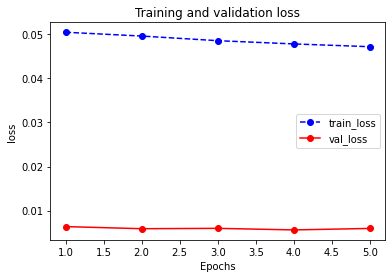

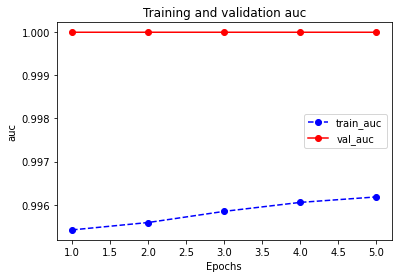

In [252]:
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [255]:
# 预测
y_pred_probs = model([torch.tensor(test_X[0].reshape(-1,1)).float(), torch.tensor(test_X[1].reshape(-1,1)).float(), torch.tensor(test_X[2]).float(), torch.tensor(test_X[3]).float()])
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
test_auc = auc(y_pred_probs.data.numpy(), test_y)
test_acc = accuracy_score(test_y, y_pred.data.numpy())
print('test_auc:%.3f, test_acc:%.3f'%(test_auc, test_acc))

test_auc:0.504, test_acc:0.500
